In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, f1_score, auc, roc_auc_score, classification_report, roc_curve, confusion_matrix

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import variable

print(torch.__version__)
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2.0.0+cu118
True
cuda:0


In [3]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.metrics import Metric

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from imblearn.over_sampling import SMOTE

In [250]:
dat = pd.read_csv('[urp] 전처리 한 데이터.csv')
dat.head()

,BIZ_NO,결산년월,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부채총계,...,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,MDSCO_PRTC_YN,ESTB_GB,EMP_CNT,Industry,Stock_OX,신생기업여부,Target
0,6998800583,20220331,24965602.0,0.0,219000.0,0.0,25184602.0,1999913.0,0.0,1999913.0,...,1,N,N,N,1,2.0,K,(주),2,1
1,5168100635,20211231,615988.0,185615.0,42385.0,14120.0,658373.0,494966.0,103545.0,598511.0,...,1,N,Y,N,1,10.0,J,(주),2,1
2,1348715772,20211231,1596577.0,3802.0,353082.0,39340.0,1949659.0,771535.0,194663.0,966198.0,...,1,N,Y,N,1,14.0,J,(주),1,1
3,5158115284,20211231,30077990.0,6034264.0,15251977.0,7279856.0,45329967.0,15391552.0,5304808.0,20696360.0,...,1,N,Y,N,1,173.0,C,(주),1,1
4,1348631964,20211231,28431311.0,15498763.0,21334735.0,19795298.0,49766046.0,28142492.0,638761.0,28781253.0,...,1,N,Y,N,1,113.0,C,(주),1,1


In [251]:
dat.Industry[np.where(dat.Industry.isna())[0]] = 'UNKNOWN'


<ipython-input-251-cb372fbae4eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.Industry[np.where(dat.Industry.isna())[0]] = 'UNKNOWN'


In [252]:
X = dat.drop(['BIZ_NO', '결산년월', 'Target'], axis=1)
Y = dat.Target

In [253]:
nunique = X.nunique()
types = X.dtypes

categorical_columns = []
categorical_dims =  {}
for col in X.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, X[col].nunique())
        l_enc = LabelEncoder()
        X[col] = l_enc.fit_transform(X[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)

재무결측치개수 28
HDOF_BR_GB 2
FR_IVST_CORP_YN 2
VENT_YN 2
MDSCO_PRTC_YN 2
ESTB_GB 8
Industry 20
Stock_OX 5
신생기업여부 3


In [261]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 1)
X_train.reset_index(inplace=True)
X_train.drop(['index'], axis=1, inplace=True)
X_test.reset_index(inplace=True)
X_test.drop(['index'], axis=1, inplace=True)


In [260]:
X_train.drop(['index'], axis=1)


,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부채총계,자본금,이익잉여금(결손금）,...,재무결측치개수,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,MDSCO_PRTC_YN,ESTB_GB,EMP_CNT,Industry,Stock_OX,신생기업여부
0,18838552.0,3137910.0,28359844.0,732255.0,47198396.0,3713215.0,100061.0,3813276.0,300000.0,80203741.0,...,0,1,0,0,0,0,1.0,6,2,0
1,79765665.0,47403555.0,155963991.0,59710156.0,235729655.0,37510714.0,30376254.0,67886968.0,812440.0,154936705.0,...,0,0,0,0,0,0,266.0,2,2,1
2,3497496.0,82500.0,10540479.0,10189327.0,14037974.0,69497.0,8198468.0,8267964.0,150000.0,5620949.0,...,2,0,0,0,0,0,4.0,11,2,1
3,42646474.0,26685863.0,12518583.0,11361764.0,55165057.0,24547545.0,12645325.0,37192870.0,2000000.0,15972187.0,...,2,1,0,0,0,0,140.0,2,2,1
4,9034862.0,5197279.0,650814.0,550814.0,9685676.0,5830986.0,2543865.0,8374850.0,300000.0,1010826.0,...,1,0,0,0,0,0,32.0,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25031,23100210.0,9605962.0,27969085.0,26826557.0,51069296.0,19816957.0,19849764.0,39666721.0,503900.0,7389209.0,...,2,0,0,0,0,0,71.0,2,2,1
25032,2769462.0,63125.0,26630161.0,7058.0,29399623.0,41153604.0,144000.0,41297604.0,1729740.0,-144891405.0,...,4,0,0,0,0,0,0.0,12,2,1
25033,3989284.0,349449.0,6719751.0,4958921.0,10709035.0,4112871.0,2488137.0,6601008.0,1500000.0,958026.0,...,1,0,0,0,0,0,106.0,6,2,1
25034,7170196.0,1643686.0,2529743.0,1842300.0,9699939.0,3484265.0,1340095.0,4824360.0,300000.0,3946285.0,...,1,0,0,1,0,0,151.0,9,2,1


## **LGBM 모델링**


In [270]:
# 하이퍼 파라미터 튜닝 : Optuna
import lightgbm as lgb

def objective(trial, data=X_train, target=Y_train):
    
    param = {
        "objective": "binary", 'random_state': 1,
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'device' : 'gpu'
    }

    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    CV_score_array    =[]
    for train_index, test_index in kf.split(data):
        x_train, x_valid = data.iloc[train_index,:], data.iloc[test_index,:]
        y_train, y_valid = target.iloc[train_index], target.iloc[test_index]

        dtrain = lgb.Dataset(x_train, label=y_train)
        model = lgb.train(param, dtrain)
        
        prob = model.predict(x_valid)
        pred_class = np.where(prob > 0.5, 1 , 0) 
        CV_score_array.append(f1_score(pred_class, y_valid))

    avg = np.mean(CV_score_array)
    return avg

In [271]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(multivariate=True, seed=1))
study.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


c:\Users\elcax\anaconda3\lib\site-packages\optuna\samplers\_tpe\sampler.py:278: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-06-23 12:02:54,818] A new study created in memory with name: no-name-88cb5b62-4411-4245-beef-4ae49ff684bf
[I 2023-06-23 12:03:00,723] Trial 0 finished with value: 0.7760579112919818 and parameters: {'lambda_l1': 5.6649755830282306e-05, 'lambda_l2': 0.030403280126677572, 'num_leaves': 2, 'feature_fraction': 0.5813995435791038, 'bagging_fraction': 0.48805353449026784, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 0 with value: 0.7760579112919818.
[I 2023-06-23 12:03:14,042] Trial 1 finished with value: 0.860053476742416 and parameters: {'lambda_l1': 1.2883876209377052e-05, 'lambda_l2': 3.72312200494449e-05, 'num_leaves': 139, 'feature_fraction': 0.6515167086419769, 'bagging_fraction': 0.8111317002380557, 'bagging_freq': 2, 'min_child_samples': 89}. Best is tria

Number of finished trials: 500
Best trial: {'lambda_l1': 2.7643711928488506e-08, 'lambda_l2': 0.0003764176902587699, 'num_leaves': 56, 'feature_fraction': 0.61900429624094, 'bagging_fraction': 0.9868010346919188, 'bagging_freq': 5, 'min_child_samples': 41}


In [102]:
print(study.best_params)
print(study.best_trials)

{'lambda_l1': 2.823404082857056e-07, 'lambda_l2': 1.4606489689133971e-08, 'num_leaves': 94, 'feature_fraction': 0.6300817500795906, 'bagging_fraction': 0.8865837976668427, 'bagging_freq': 4, 'min_child_samples': 55}
[FrozenTrial(number=489, state=TrialState.COMPLETE, values=[0.999572756246663], datetime_start=datetime.datetime(2023, 6, 22, 6, 19, 46, 287773), datetime_complete=datetime.datetime(2023, 6, 22, 6, 19, 54, 50384), params={'lambda_l1': 2.823404082857056e-07, 'lambda_l2': 1.4606489689133971e-08, 'num_leaves': 94, 'feature_fraction': 0.6300817500795906, 'bagging_fraction': 0.8865837976668427, 'bagging_freq': 4, 'min_child_samples': 55}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False,

In [272]:
lgbm = lgb.LGBMClassifier(**study.best_params) 
lgbm.fit(X_train,Y_train)
y_pred = lgbm.predict_proba(X_test)


[LightGBM] [Warning] feature_fraction is set=0.61900429624094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.61900429624094
[LightGBM] [Warning] lambda_l1 is set=2.7643711928488506e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7643711928488506e-08
[LightGBM] [Warning] bagging_fraction is set=0.9868010346919188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9868010346919188
[LightGBM] [Warning] lambda_l2 is set=0.0003764176902587699, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003764176902587699
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


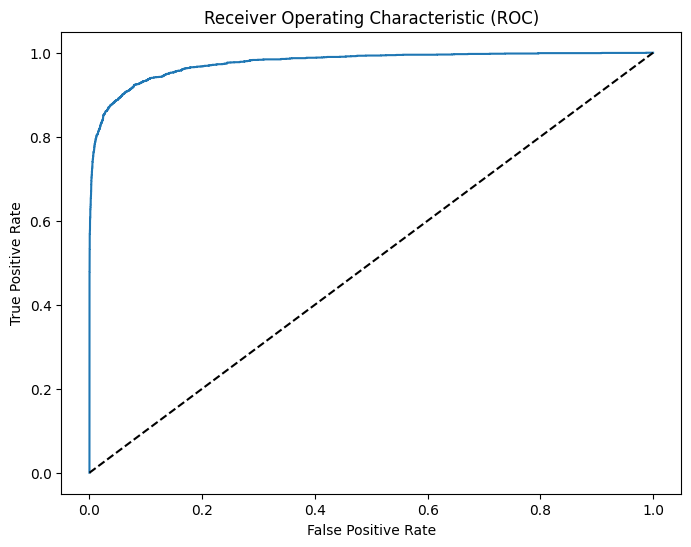

AUC Score: 0.9761439394661694


In [273]:
# ROC 곡선 생성
fpr, tpr, thresholds = roc_curve(Y_test, y_pred[:,1])

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # 기준 선 (랜덤 모델)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.show()
#auc 계산
from sklearn.metrics import roc_curve, roc_auc_score
auc_score = roc_auc_score(y_score=y_pred[:,1], y_true=Y_test)

print("AUC Score:", auc_score)

In [274]:
#KS Score
from scipy import interpolate
from scipy import spatial
from scipy import stats
from scipy.cluster import hierarchy

prediction_LGBM = lgbm.predict(X_test)

print('Random Forest 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_LGBM)[Y_test.reset_index(drop=True)==0].values.flatten(), 
               pd.DataFrame(prediction_LGBM)[Y_test.reset_index(drop=True)==1].values.flatten())

Random Forest 모델 KS Score :


KstestResult(statistic=0.7911007676928218, pvalue=9.54e-322, statistic_location=0, statistic_sign=1)

In [275]:
print(classification_report(Y_test, prediction_LGBM))
f1_score(Y_test, prediction_LGBM)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8644
           1       0.93      0.80      0.86      2087

    accuracy                           0.95     10731
   macro avg       0.94      0.90      0.92     10731
weighted avg       0.95      0.95      0.95     10731



0.8644198610753795

In [276]:
cm2 = confusion_matrix(Y_test,prediction_LGBM)
cmdf2 = pd.DataFrame(cm2, index=['실제값(0)', '실제값(1)'], columns=['예측값(0)', '예측값(1)'])
cmdf2

,예측값(0),예측값(1)
실제값(0),8524,120
실제값(1),407,1680


In [277]:
# 그냥 확인하기에 피쳐종류가 30개나 되어 한눈에 들어오지 않는다.
print(lgbm.feature_importances_, '\n')

# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(lgbm.feature_importances_, index=dat.drop(['BIZ_NO', '결산년월', 'Target'], axis=1).columns)

# 내림차순 정렬을 이용한다
top15 = ser.sort_values(ascending=False)[:15]
print(top15)

[121 134 105 100 131 112 141 152 158 112 105 149 142 128  57  72  84 131
  72 116 109  78  88  71 296  76  82 165  75  65  88  62  98  52  57 148
 110  91 168 144 104  90 100 114  57  55   2  17   0  15 310 119   9  63] 

EMP_CNT         310
경상수지비율(%)       296
매출채권회전율(%)      168
금융비용대부채비율(%)    165
자본금             158
부채총계            152
매출액             149
부채총계대 매출액(%)    148
매입채무회전율(%)      144
판매비와관리비         142
비유동부채           141
매출채권            134
기업순이익률(%)       131
자산총계            131
영업이익(손실)        128
dtype: int32


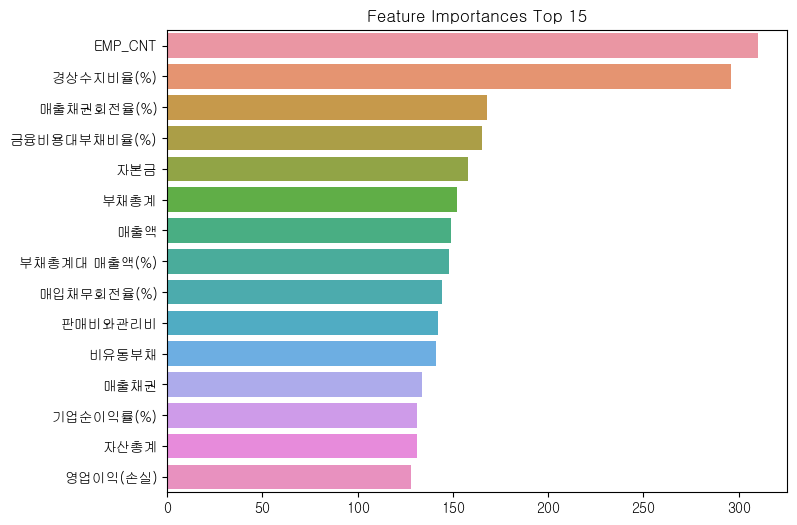

In [278]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns

font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()


**shap value 계산**

In [317]:
import shap

explainer = shap.TreeExplainer(lgbm) ## Explainer 객체 생성
expected_value = explainer.expected_value ## Base SHAP Value
shap_values = explainer.shap_values(X_train) ## SHAP Value
shap_obj = explainer(X_train)
 
print('SHAP Value :', shap_values)
print('예측값 :', prediction_LGBM)
print('SHAP Value 합 :', np.sum(shap_values)+expected_value)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


SHAP Value : [array([[ 0.13265756, -0.04745819,  0.11903262, ...,  0.04943674,
         0.00191267, -0.11745694],
       [ 0.04813865, -0.05450494, -0.0031281 , ..., -0.03243086,
        -0.00093615,  0.13750279],
       [ 0.02357312,  0.10555975,  0.1682887 , ...,  0.03380342,
         0.00185159,  0.05578314],
       ...,
       [ 0.05887019,  0.01148329,  0.03460699, ...,  0.07460526,
         0.00463722,  0.0463485 ],
       [ 0.09020798,  0.02545896, -0.03251874, ..., -0.02521297,
         0.00255261,  0.05318774],
       [ 0.15665456,  0.03440181,  0.08043047, ...,  0.08455386,
        -0.12850123, -0.11129757]]), array([[-0.13265756,  0.04745819, -0.11903262, ..., -0.04943674,
        -0.00191267,  0.11745694],
       [-0.04813865,  0.05450494,  0.0031281 , ...,  0.03243086,
         0.00093615, -0.13750279],
       [-0.02357312, -0.10555975, -0.1682887 , ..., -0.03380342,
        -0.00185159, -0.05578314],
       ...,
       [-0.05887019, -0.01148329, -0.03460699, ..., -0.07460

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


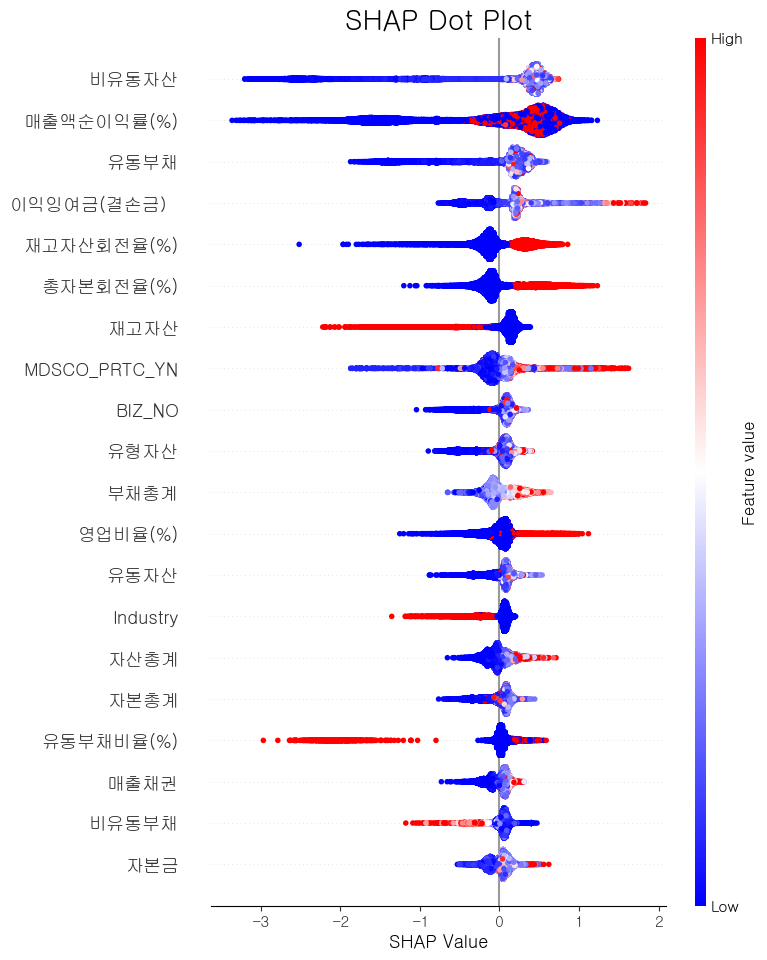

In [332]:
## Dot Plot
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
 
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values[0], X_train, 
                  feature_names=dat.columns, ## 변수명 표시
                  cmap='bwr', ## 컬러맵
                  show=False, ## 기존 X축 라벨 표시 안함
                 )
ax.set_xlabel('SHAP Value')
ax.set_title('SHAP Dot Plot', fontsize=20)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


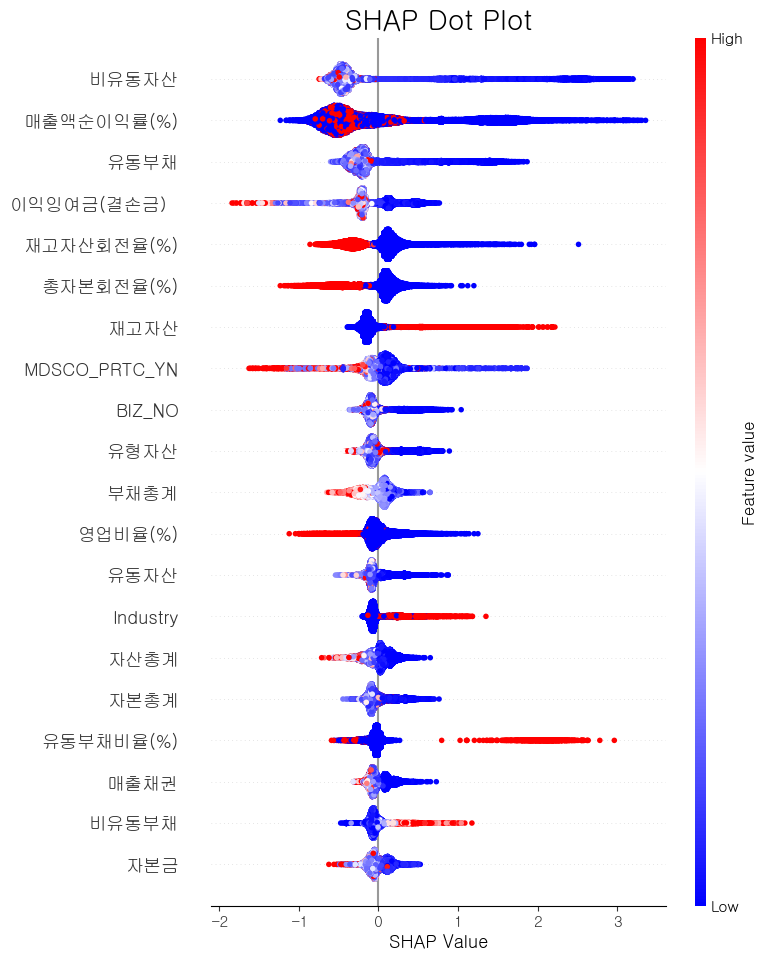

In [331]:
## Dot Plot
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values[1], X_train, 
                  feature_names=dat.columns, ## 변수명 표시
                  cmap='bwr', ## 컬러맵
                  show=False, ## 기존 X축 라벨 표시 안함
                 )
ax.set_xlabel('SHAP Value')
ax.set_title('SHAP Dot Plot', fontsize=20)
plt.show()

In [285]:
# 첫 번째 데이터에 대한 SHAP 시각화
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test.iloc[0])

## **TabNet 모델링**

In [105]:
dat = pd.read_csv('[urp] 전처리 한 데이터.csv')
dat.head()

,BIZ_NO,결산년월,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부채총계,...,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,MDSCO_PRTC_YN,ESTB_GB,EMP_CNT,Industry,Stock_OX,신생기업여부,Target
0,6998800583,20220331,24965602.0,0.0,219000.0,0.0,25184602.0,1999913.0,0.0,1999913.0,...,1,N,N,N,1,2.0,K,(주),2,1
1,5168100635,20211231,615988.0,185615.0,42385.0,14120.0,658373.0,494966.0,103545.0,598511.0,...,1,N,Y,N,1,10.0,J,(주),2,1
2,1348715772,20211231,1596577.0,3802.0,353082.0,39340.0,1949659.0,771535.0,194663.0,966198.0,...,1,N,Y,N,1,14.0,J,(주),1,1
3,5158115284,20211231,30077990.0,6034264.0,15251977.0,7279856.0,45329967.0,15391552.0,5304808.0,20696360.0,...,1,N,Y,N,1,173.0,C,(주),1,1
4,1348631964,20211231,28431311.0,15498763.0,21334735.0,19795298.0,49766046.0,28142492.0,638761.0,28781253.0,...,1,N,Y,N,1,113.0,C,(주),1,1


In [106]:
dat.Industry[np.where(dat.Industry.isna())[0]] = 'UNKNOWN'


<ipython-input-106-cb372fbae4eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.Industry[np.where(dat.Industry.isna())[0]] = 'UNKNOWN'


In [107]:
train = dat.drop(['BIZ_NO', '결산년월'], axis=1)
target = 'Target'



In [108]:
nunique = train.drop(['Target'], axis=1).nunique()
types = train.drop(['Target'], axis=1).dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.drop(['Target'], axis=1).columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)

# Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.
unused_feat = ['Set']
features = [ col for col in train.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


재무결측치개수 28
HDOF_BR_GB 2
FR_IVST_CORP_YN 2
VENT_YN 2
MDSCO_PRTC_YN 2
ESTB_GB 8
Industry 20
Stock_OX 5
신생기업여부 3


In [109]:
train_index, test_index = train_test_split(train, test_size=0.3, random_state = 1)

X = train.drop(['Target'], axis=1).values[train_index.index]
X_test = train.drop(['Target'], axis=1).values[test_index.index]

y = train['Target'].values[train_index.index]
y_test = train['Target'].values[test_index.index]


In [110]:
class F1_Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        score = f1_score(y_true, (y_score[:, 1]>0.5)*1)
        return score

In [120]:
def objective(trial):

    hyperparams = {
        'n_a_d': trial.suggest_categorical('n_a_d', [8, 16, 24, 32, 64, 128]),
        'n_steps': trial.suggest_int('n_steps', 3, 10, 1),
        'gamma': trial.suggest_categorical('gamma', [1.0, 1.2, 1.5, 2.0]),
        'lambda': trial.suggest_categorical('lambda', [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0]),
        'batch_size': trial.suggest_categorical('batch_size', [1024, 2048, 4096, 8192, 16384, 32768]),
        'virtual_batch_size': trial.suggest_categorical('virtual_batch_size', [128, 256, 512, 1024]),
        'lr': trial.suggest_categorical('lr', [0.005, 0.01, 0.02, 0.025]),
        'gamma_decay': trial.suggest_categorical('gamma_decay', [0.4, 0.8, 0.9, 0.95]),
        'mask_type': trial.suggest_categorical('mask_type', ['entmax', 'sparsemax']),
        'batch_momentum': trial.suggest_categorical('batch_momentum', [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]),
        'PATIENCE' : trial.suggest_int('n_steps', 3, 10, 1)
    }
    MAX_EPOCHS = 100

    try:
        # Your existing code for the objective function
        kf = KFold(n_splits=5, random_state=1, shuffle=True)
        CV_score_array    =[]
        for train_index, test_index in kf.split(X):
            X_train, X_valid = X[train_index], X[test_index]
            y_train, y_valid = y[train_index], y[test_index]

            pre = TabNetPretrainer(
                n_d=hyperparams['n_a_d'],
                n_a=hyperparams['n_a_d'],
                gamma=hyperparams['gamma'],
                optimizer_fn=torch.optim.Adam,
                optimizer_params={'lr':hyperparams['lr']},
                scheduler_params={"step_size":hyperparams['n_steps'],
                                "gamma":hyperparams['gamma_decay']},
                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                mask_type=hyperparams['mask_type'],
                lambda_sparse=hyperparams['lambda'],
                momentum=hyperparams['batch_momentum'],
                verbose = 0
                )

            pre.fit(
                X_train=X_train,
                eval_set=[X_valid],
                pretraining_ratio=0.8,
            )

            model = TabNetClassifier(
                n_d=hyperparams['n_a_d'],
                n_a=hyperparams['n_a_d'],
                gamma=hyperparams['gamma'],
                optimizer_fn=torch.optim.Adam,
                optimizer_params={'lr':hyperparams['lr']},
                scheduler_params={"step_size":hyperparams['n_steps'],
                                "gamma":hyperparams['gamma_decay']},
                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                mask_type=hyperparams['mask_type'],
                lambda_sparse=hyperparams['lambda'],
                momentum=hyperparams['batch_momentum'],
                verbose = 0
            )
            model.fit(
                X_train=X_train, y_train=y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                eval_name=['train', 'val'],
                max_epochs=MAX_EPOCHS, 
                patience=hyperparams['PATIENCE'],
                batch_size = hyperparams['batch_size'],    # 1024,
                virtual_batch_size = hyperparams['virtual_batch_size'],    # 128,
                num_workers=0,
                eval_metric=['auc'], 
                from_unsupervised=pre ,
                drop_last=False
            )

            val_preds = roc_auc_score(y_score = model.predict_proba(X_valid)[:,1], y_true = y_valid)
            CV_score_array.append(val_preds)
        
        avg = np.mean(CV_score_array)
        # Return the objective value
        return avg
    except Exception as e:
        # Print the error message if needed
        print("Error occurred in trial:", trial.number)
        print(e)
        
        # Return a default value (such as 0) for failed trials
        return 0




In [121]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(multivariate=True, seed=1))

study.optimize(objective, 
               timeout=3*60*60, 
               n_trials=150, 
               gc_after_trial=False)


c:\Users\elcax\anaconda3\lib\site-packages\optuna\samplers\_tpe\sampler.py:278: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-06-22 16:25:02,245] A new study created in memory with name: no-name-ced36c95-bf1e-4db6-b6b3-3f18abd65362



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.1356600522994995


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 6 with best_epoch = 2 and best_val_auc = 0.64425


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_unsup_loss_numpy = 1.1257699728012085


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 17 with best_epoch = 13 and best_val_auc = 0.72992


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_unsup_loss_numpy = 1.0955400466918945


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 19 with best_epoch = 15 and best_val_auc = 0.72741


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.1115399599075317


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 12 with best_epoch = 8 and best_val_auc = 0.66863


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.0967199802398682


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 6 with best_epoch = 2 and best_val_auc = 0.71941


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 16:27:36,425] Trial 0 finished with value: 0.6979240815784024 and parameters: {'n_a_d': 16, 'n_steps': 4, 'gamma': 1.5, 'lambda': 0.001, 'batch_size': 8192, 'virtual_batch_size': 256, 'lr': 0.01, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 0 with value: 0.6979240815784024.



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.1561800241470337


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_auc = 0.90414


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_unsup_loss_numpy = 1.143839955329895


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 7 with best_epoch = 4 and best_val_auc = 0.85336


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_unsup_loss_numpy = 1.1278899908065796


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_auc = 0.87099


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_unsup_loss_numpy = 1.141319990158081


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_auc = 0.7778


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_unsup_loss_numpy = 1.123170018196106


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_auc = 0.87901


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 16:30:12,910] Trial 1 finished with value: 0.8570596288058283 and parameters: {'n_a_d': 24, 'n_steps': 3, 'gamma': 1.0, 'lambda': 1e-05, 'batch_size': 1024, 'virtual_batch_size': 128, 'lr': 0.01, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 1 with value: 0.8570596288058283.



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_unsup_loss_numpy = 1.134950041770935


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 21 and best_val_auc = 0.87637


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_unsup_loss_numpy = 1.1005200147628784


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 24 with best_epoch = 18 and best_val_auc = 0.90525


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 65 with best_epoch = 55 and best_val_0_unsup_loss_numpy = 1.0604300498962402


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 25 with best_epoch = 19 and best_val_auc = 0.91812


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_unsup_loss_numpy = 1.0939099788665771


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 24 with best_epoch = 18 and best_val_auc = 0.91957


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.131350040435791


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 42 with best_epoch = 36 and best_val_auc = 0.93363


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 16:34:31,275] Trial 2 finished with value: 0.9105875204170767 and parameters: {'n_a_d': 32, 'n_steps': 6, 'gamma': 1.2, 'lambda': 1e-06, 'batch_size': 8192, 'virtual_batch_size': 128, 'lr': 0.01, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 2 with value: 0.9105875204170767.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_unsup_loss_numpy = 1.0903400182724


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 26 with best_epoch = 17 and best_val_auc = 0.93114


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.0925999879837036


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 11 with best_epoch = 2 and best_val_auc = 0.82966


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 73 with best_epoch = 63 and best_val_0_unsup_loss_numpy = 1.062849998474121


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 12 and best_val_auc = 0.94249


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_unsup_loss_numpy = 1.0871200561523438


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 10 with best_epoch = 1 and best_val_auc = 0.85969


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_unsup_loss_numpy = 1.0722500085830688


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 32 with best_epoch = 23 and best_val_auc = 0.93481


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 16:37:58,417] Trial 3 finished with value: 0.8995573913487858 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 1.0, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 512, 'lr': 0.025, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.7}. Best is trial 2 with value: 0.9105875204170767.



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.1193300485610962


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 40 with best_epoch = 31 and best_val_auc = 0.86362


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 66 with best_epoch = 56 and best_val_0_unsup_loss_numpy = 1.099269986152649


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 72 with best_epoch = 63 and best_val_auc = 0.90059


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.094849944114685


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 51 with best_epoch = 42 and best_val_auc = 0.89429


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.1071200370788574


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 26 with best_epoch = 17 and best_val_auc = 0.84227


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.0696699619293213


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 62 with best_epoch = 53 and best_val_auc = 0.89209


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 16:43:02,294] Trial 4 finished with value: 0.8785729696875559 and parameters: {'n_a_d': 8, 'n_steps': 9, 'gamma': 1.5, 'lambda': 0.001, 'batch_size': 32768, 'virtual_batch_size': 128, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 2 with value: 0.9105875204170767.



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_unsup_loss_numpy = 1.1227699518203735


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 17 with best_epoch = 10 and best_val_auc = 0.83888


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_unsup_loss_numpy = 1.0948699712753296


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 36 with best_epoch = 29 and best_val_auc = 0.90969


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_unsup_loss_numpy = 1.1058000326156616


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 20 and best_val_auc = 0.921


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_unsup_loss_numpy = 1.1009000539779663


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 14 and best_val_auc = 0.87997


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 85 with best_epoch = 75 and best_val_0_unsup_loss_numpy = 1.0479099750518799


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 38 with best_epoch = 31 and best_val_auc = 0.93116


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 16:47:09,214] Trial 5 finished with value: 0.896138947140301 and parameters: {'n_a_d': 128, 'n_steps': 7, 'gamma': 1.5, 'lambda': 0.01, 'batch_size': 8192, 'virtual_batch_size': 128, 'lr': 0.025, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.9}. Best is trial 2 with value: 0.9105875204170767.



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_unsup_loss_numpy = 1.1275800466537476


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 7 with best_epoch = 1 and best_val_auc = 0.57133


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_unsup_loss_numpy = 1.1127400398254395


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 48 with best_epoch = 42 and best_val_auc = 0.84943


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_unsup_loss_numpy = 1.0951000452041626


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 66 with best_epoch = 60 and best_val_auc = 0.89018


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_unsup_loss_numpy = 1.1176799535751343


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 47 with best_epoch = 41 and best_val_auc = 0.86822


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_unsup_loss_numpy = 1.084529995918274


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 16:50:58,059] Trial 6 finished with value: 0.8099504885569614 and parameters: {'n_a_d': 8, 'n_steps': 6, 'gamma': 2.0, 'lambda': 0, 'batch_size': 8192, 'virtual_batch_size': 1024, 'lr': 0.005, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 2 with value: 0.9105875204170767.



Early stopping occurred at epoch 34 with best_epoch = 28 and best_val_auc = 0.8706

Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_unsup_loss_numpy = 1.1085699796676636


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 10 with best_epoch = 6 and best_val_auc = 0.65209


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_unsup_loss_numpy = 1.0993000268936157


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 16 with best_epoch = 12 and best_val_auc = 0.67658


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 42 and best_val_0_unsup_loss_numpy = 1.0814100503921509


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 26 with best_epoch = 22 and best_val_auc = 0.69751


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_unsup_loss_numpy = 1.1049400568008423


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 36 with best_epoch = 32 and best_val_auc = 0.7567


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_unsup_loss_numpy = 1.102329969406128


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 7 with best_epoch = 3 and best_val_auc = 0.58009


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 16:54:05,260] Trial 7 finished with value: 0.6725943436869659 and parameters: {'n_a_d': 24, 'n_steps': 4, 'gamma': 1.2, 'lambda': 0.1, 'batch_size': 32768, 'virtual_batch_size': 512, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 2 with value: 0.9105875204170767.



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_unsup_loss_numpy = 1.1143499612808228


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 51 with best_epoch = 42 and best_val_auc = 0.93362


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.1118600368499756


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 60 with best_epoch = 51 and best_val_auc = 0.941


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_unsup_loss_numpy = 1.0825200080871582


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 49 with best_epoch = 40 and best_val_auc = 0.91739


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.0992900133132935


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 35 with best_epoch = 26 and best_val_auc = 0.92704


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_unsup_loss_numpy = 1.0609400272369385


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 30 with best_epoch = 21 and best_val_auc = 0.90978


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 16:58:13,209] Trial 8 finished with value: 0.9257661230248908 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 1.0, 'lambda': 0.0001, 'batch_size': 8192, 'virtual_batch_size': 128, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 8 with value: 0.9257661230248908.



Early stopping occurred at epoch 53 with best_epoch = 43 and best_val_0_unsup_loss_numpy = 1.093809962272644


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_auc = 0.82049


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_unsup_loss_numpy = 1.1050200462341309


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_auc = 0.71258


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_unsup_loss_numpy = 1.0908399820327759


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_auc = 0.84737


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.1032999753952026


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 6 with best_epoch = 3 and best_val_auc = 0.85107


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_unsup_loss_numpy = 1.0726300477981567


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 8 with best_epoch = 5 and best_val_auc = 0.83286


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:00:40,696] Trial 9 finished with value: 0.8128726143061418 and parameters: {'n_a_d': 64, 'n_steps': 3, 'gamma': 1.5, 'lambda': 1e-06, 'batch_size': 4096, 'virtual_batch_size': 128, 'lr': 0.025, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 8 with value: 0.9257661230248908.



Early stopping occurred at epoch 79 with best_epoch = 69 and best_val_0_unsup_loss_numpy = 1.091729998588562


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.73542


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_unsup_loss_numpy = 1.1098099946975708


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_auc = 0.8153


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.080899953842163


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.89417


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.1013200283050537


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_auc = 0.85747


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_unsup_loss_numpy = 1.0721100568771362


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_auc = 0.8165


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:04:06,575] Trial 10 finished with value: 0.8237736795880093 and parameters: {'n_a_d': 64, 'n_steps': 5, 'gamma': 1.0, 'lambda': 1e-05, 'batch_size': 8192, 'virtual_batch_size': 128, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.9}. Best is trial 8 with value: 0.9257661230248908.



Early stopping occurred at epoch 54 with best_epoch = 44 and best_val_0_unsup_loss_numpy = 1.1021599769592285


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 14 and best_val_auc = 0.8372


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_unsup_loss_numpy = 1.1005300283432007


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 25 with best_epoch = 18 and best_val_auc = 0.90846


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 62 with best_epoch = 52 and best_val_0_unsup_loss_numpy = 1.070449948310852


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 25 with best_epoch = 18 and best_val_auc = 0.91389


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_unsup_loss_numpy = 1.1027300357818604


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 10 with best_epoch = 3 and best_val_auc = 0.86399


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.0780800580978394


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 26 with best_epoch = 19 and best_val_auc = 0.89813


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:09:01,221] Trial 11 finished with value: 0.8843354739885616 and parameters: {'n_a_d': 32, 'n_steps': 7, 'gamma': 1.2, 'lambda': 0.0001, 'batch_size': 1024, 'virtual_batch_size': 128, 'lr': 0.01, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 8 with value: 0.9257661230248908.



Early stopping occurred at epoch 50 with best_epoch = 40 and best_val_0_unsup_loss_numpy = 1.1000499725341797


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 19 with best_epoch = 10 and best_val_auc = 0.87203


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_unsup_loss_numpy = 1.0976500511169434


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 25 with best_epoch = 16 and best_val_auc = 0.89415


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_unsup_loss_numpy = 1.070639967918396


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 37 with best_epoch = 28 and best_val_auc = 0.93159


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_unsup_loss_numpy = 1.1092300415039062


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 54 with best_epoch = 45 and best_val_auc = 0.9287


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.0770900249481201


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:12:57,355] Trial 12 finished with value: 0.9111451395107544 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 2.0, 'lambda': 0.0001, 'batch_size': 8192, 'virtual_batch_size': 256, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 8 with value: 0.9257661230248908.



Early stopping occurred at epoch 42 with best_epoch = 33 and best_val_auc = 0.92925

Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_unsup_loss_numpy = 1.1008199453353882


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 23 with best_epoch = 14 and best_val_auc = 0.86733


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_unsup_loss_numpy = 1.0983500480651855


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 50 with best_epoch = 41 and best_val_auc = 0.92714


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 70 with best_epoch = 60 and best_val_0_unsup_loss_numpy = 1.0662100315093994


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 12 with best_epoch = 3 and best_val_auc = 0.8128


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 58 with best_epoch = 48 and best_val_0_unsup_loss_numpy = 1.0882799625396729


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 18 and best_val_auc = 0.89831


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_unsup_loss_numpy = 1.063789963722229


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 41 with best_epoch = 32 and best_val_auc = 0.92883


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:17:25,415] Trial 13 finished with value: 0.8868807848979042 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 1.2, 'lambda': 0.001, 'batch_size': 8192, 'virtual_batch_size': 128, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 8 with value: 0.9257661230248908.



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_unsup_loss_numpy = 1.1008199453353882


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 26 with best_epoch = 17 and best_val_auc = 0.90254


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.1319799423217773


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 45 with best_epoch = 36 and best_val_auc = 0.93156


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_unsup_loss_numpy = 1.0828700065612793


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 33 with best_epoch = 24 and best_val_auc = 0.93075


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 43 and best_val_0_unsup_loss_numpy = 1.0812100172042847


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 9 with best_epoch = 0 and best_val_auc = 0.76321


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.0762399435043335


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 15 with best_epoch = 6 and best_val_auc = 0.82531


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:20:28,357] Trial 14 finished with value: 0.8706734643493382 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 2.0, 'lambda': 0.0001, 'batch_size': 8192, 'virtual_batch_size': 256, 'lr': 0.025, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 8 with value: 0.9257661230248908.



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_unsup_loss_numpy = 1.1068600416183472


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_auc = 0.84691


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.104509949684143


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_auc = 0.91754


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.0868200063705444


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_auc = 0.9144


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.094980001449585


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_auc = 0.93113


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.1240500211715698


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_auc = 0.91503


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:23:59,217] Trial 15 finished with value: 0.9050022159868221 and parameters: {'n_a_d': 128, 'n_steps': 10, 'gamma': 1.5, 'lambda': 1e-05, 'batch_size': 8192, 'virtual_batch_size': 256, 'lr': 0.02, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 8 with value: 0.9257661230248908.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_unsup_loss_numpy = 1.0975300073623657


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 48 with best_epoch = 41 and best_val_auc = 0.8694


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_unsup_loss_numpy = 1.106819987297058


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 57 with best_epoch = 50 and best_val_auc = 0.89507


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_unsup_loss_numpy = 1.0938199758529663


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 18 with best_epoch = 11 and best_val_auc = 0.78539


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 44 and best_val_0_unsup_loss_numpy = 1.0900299549102783


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 52 with best_epoch = 45 and best_val_auc = 0.86312


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_unsup_loss_numpy = 1.0728600025177002


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:27:32,564] Trial 16 finished with value: 0.8296593369840124 and parameters: {'n_a_d': 16, 'n_steps': 7, 'gamma': 2.0, 'lambda': 0.0001, 'batch_size': 32768, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 8 with value: 0.9257661230248908.



Early stopping occurred at epoch 12 with best_epoch = 5 and best_val_auc = 0.73532

Early stopping occurred at epoch 58 with best_epoch = 48 and best_val_0_unsup_loss_numpy = 1.0987399816513062


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 13 and best_val_auc = 0.90752


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.0921000242233276


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 37 with best_epoch = 29 and best_val_auc = 0.90725


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_unsup_loss_numpy = 1.084380030632019


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 20 and best_val_auc = 0.88838


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.109089970588684


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 13 with best_epoch = 5 and best_val_auc = 0.85028


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_unsup_loss_numpy = 1.0746899843215942


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 13 and best_val_auc = 0.89479


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:31:32,587] Trial 17 finished with value: 0.8896441045413812 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 2.0, 'lambda': 1e-06, 'batch_size': 1024, 'virtual_batch_size': 256, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 8 with value: 0.9257661230248908.



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.1003700494766235


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_auc = 0.92247


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_unsup_loss_numpy = 1.0940200090408325


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_auc = 0.94291


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_unsup_loss_numpy = 1.079859972000122


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_auc = 0.94922


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_unsup_loss_numpy = 1.0970200300216675


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_auc = 0.94166


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_unsup_loss_numpy = 1.0690399408340454


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_auc = 0.94569


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:35:03,216] Trial 18 finished with value: 0.9403882449199201 and parameters: {'n_a_d': 64, 'n_steps': 10, 'gamma': 1.0, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_unsup_loss_numpy = 1.096459984779358


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_auc = 0.9353


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.0991699695587158


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_auc = 0.85587


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 70 with best_epoch = 60 and best_val_0_unsup_loss_numpy = 1.0563700199127197


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_auc = 0.94869


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 42 and best_val_0_unsup_loss_numpy = 1.0881799459457397


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_auc = 0.80368


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_unsup_loss_numpy = 1.0601600408554077


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_auc = 0.85044


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:39:02,570] Trial 19 finished with value: 0.8787939554129801 and parameters: {'n_a_d': 64, 'n_steps': 10, 'gamma': 1.2, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.0988800525665283


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 38 with best_epoch = 29 and best_val_auc = 0.92653


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_unsup_loss_numpy = 1.1190799474716187


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 19 and best_val_auc = 0.94416


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_unsup_loss_numpy = 1.082319974899292


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 12 with best_epoch = 3 and best_val_auc = 0.89065


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_unsup_loss_numpy = 1.1064399480819702


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 20 with best_epoch = 11 and best_val_auc = 0.92026


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.0638099908828735


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 15 with best_epoch = 6 and best_val_auc = 0.87303


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:42:05,267] Trial 20 finished with value: 0.9109264919394835 and parameters: {'n_a_d': 32, 'n_steps': 9, 'gamma': 1.0, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.1248600482940674


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 10 with best_epoch = 1 and best_val_auc = 0.80846


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.1096299886703491


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 15 with best_epoch = 6 and best_val_auc = 0.85766


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_unsup_loss_numpy = 1.0960500240325928


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 24 with best_epoch = 15 and best_val_auc = 0.91226


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_unsup_loss_numpy = 1.0906000137329102


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 16 with best_epoch = 7 and best_val_auc = 0.84297


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 43 and best_val_0_unsup_loss_numpy = 1.0478700399398804


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 30 with best_epoch = 21 and best_val_auc = 0.93698


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:45:52,125] Trial 21 finished with value: 0.8716678776534931 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 1.0, 'lambda': 0.0001, 'batch_size': 1024, 'virtual_batch_size': 128, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_unsup_loss_numpy = 1.0993900299072266


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 25 with best_epoch = 17 and best_val_auc = 0.86485


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 43 and best_val_0_unsup_loss_numpy = 1.09607994556427


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 36 with best_epoch = 28 and best_val_auc = 0.88194


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.0854300260543823


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 35 with best_epoch = 27 and best_val_auc = 0.90849


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.1012400388717651


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 46 with best_epoch = 38 and best_val_auc = 0.9115


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.069200038909912


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 47 with best_epoch = 39 and best_val_auc = 0.91025


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:50:11,304] Trial 22 finished with value: 0.8954069855814373 and parameters: {'n_a_d': 16, 'n_steps': 8, 'gamma': 1.0, 'lambda': 0.0001, 'batch_size': 8192, 'virtual_batch_size': 128, 'lr': 0.01, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 58 with best_epoch = 48 and best_val_0_unsup_loss_numpy = 1.0854099988937378


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 26 with best_epoch = 17 and best_val_auc = 0.92392


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_unsup_loss_numpy = 1.1032400131225586


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 48 with best_epoch = 39 and best_val_auc = 0.93625


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.0787299871444702


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 19 and best_val_auc = 0.92708


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_unsup_loss_numpy = 1.110129952430725


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 18 and best_val_auc = 0.8858


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.0774799585342407


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 15 with best_epoch = 6 and best_val_auc = 0.83667


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:54:03,835] Trial 23 finished with value: 0.9019441860592303 and parameters: {'n_a_d': 32, 'n_steps': 9, 'gamma': 1.0, 'lambda': 0, 'batch_size': 4096, 'virtual_batch_size': 128, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.1003700494766235


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 52 with best_epoch = 42 and best_val_auc = 0.91954


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_unsup_loss_numpy = 1.0940200090408325


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 66 with best_epoch = 56 and best_val_auc = 0.93056


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_unsup_loss_numpy = 1.079859972000122


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 50 with best_epoch = 40 and best_val_auc = 0.9331


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_unsup_loss_numpy = 1.0970200300216675


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_auc = 0.9103


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_unsup_loss_numpy = 1.0690399408340454


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 17:57:38,536] Trial 24 finished with value: 0.9142945164658023 and parameters: {'n_a_d': 64, 'n_steps': 10, 'gamma': 1.0, 'lambda': 0.0001, 'batch_size': 8192, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_auc = 0.87797

Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.1011500358581543


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 50 with best_epoch = 42 and best_val_auc = 0.87466


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_unsup_loss_numpy = 1.1058499813079834


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 69 with best_epoch = 61 and best_val_auc = 0.92334


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.081760048866272


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 23 with best_epoch = 15 and best_val_auc = 0.85532


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_unsup_loss_numpy = 1.093850016593933


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 34 with best_epoch = 26 and best_val_auc = 0.902


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_unsup_loss_numpy = 1.0696500539779663


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:00:59,917] Trial 25 finished with value: 0.8923549036101542 and parameters: {'n_a_d': 64, 'n_steps': 8, 'gamma': 1.0, 'lambda': 0.0001, 'batch_size': 8192, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 29 with best_epoch = 21 and best_val_auc = 0.90646

Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.1729899644851685


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_auc = 0.91816


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_unsup_loss_numpy = 1.164080023765564


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_auc = 0.88447


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_unsup_loss_numpy = 1.2131799459457397


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_auc = 0.87334


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_unsup_loss_numpy = 1.1150200366973877


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_auc = 0.89072


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.1025999784469604


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_auc = 0.91032


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:04:20,825] Trial 26 finished with value: 0.8953999765153355 and parameters: {'n_a_d': 128, 'n_steps': 10, 'gamma': 1.0, 'lambda': 0.0001, 'batch_size': 1024, 'virtual_batch_size': 512, 'lr': 0.005, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 92 with best_epoch = 82 and best_val_0_unsup_loss_numpy = 1.0977699756622314


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_auc = 0.89609


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.0940699577331543


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_auc = 0.91512


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 55 with best_epoch = 45 and best_val_0_unsup_loss_numpy = 1.076259970664978


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_auc = 0.88649


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_unsup_loss_numpy = 1.1092699766159058


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_auc = 0.90764


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_unsup_loss_numpy = 1.0799200534820557


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:09:22,952] Trial 27 finished with value: 0.9070969495376857 and parameters: {'n_a_d': 8, 'n_steps': 10, 'gamma': 1.0, 'lambda': 1e-06, 'batch_size': 16384, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.


Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_val_auc = 0.93015

Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_unsup_loss_numpy = 1.1183500289916992


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 26 with best_epoch = 17 and best_val_auc = 0.90804


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 58 with best_epoch = 48 and best_val_0_unsup_loss_numpy = 1.0949499607086182


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 15 with best_epoch = 6 and best_val_auc = 0.83563


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.0863399505615234


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 18 and best_val_auc = 0.9281


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_unsup_loss_numpy = 1.101930022239685


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 17 with best_epoch = 8 and best_val_auc = 0.81893


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_unsup_loss_numpy = 1.0849499702453613


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 43 with best_epoch = 34 and best_val_auc = 0.93373


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:12:54,240] Trial 28 finished with value: 0.8848855487059897 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 1.5, 'lambda': 0.1, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_unsup_loss_numpy = 1.1073499917984009


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_auc = 0.87361


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 66 with best_epoch = 56 and best_val_0_unsup_loss_numpy = 1.0887900590896606


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_auc = 0.88167


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_unsup_loss_numpy = 1.0701700448989868


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_auc = 0.894


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.1341899633407593


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 75 with best_epoch = 65 and best_val_auc = 0.94612


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_unsup_loss_numpy = 1.0584399700164795


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:16:28,426] Trial 29 finished with value: 0.8756035267402502 and parameters: {'n_a_d': 32, 'n_steps': 10, 'gamma': 1.5, 'lambda': 0.0001, 'batch_size': 8192, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.7}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_auc = 0.78262

Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_unsup_loss_numpy = 1.1016099452972412


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 26 with best_epoch = 17 and best_val_auc = 0.91667


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.0990300178527832


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 22 with best_epoch = 13 and best_val_auc = 0.83897


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_unsup_loss_numpy = 1.0852700471878052


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 12 and best_val_auc = 0.92877


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_unsup_loss_numpy = 1.1012500524520874


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 19 and best_val_auc = 0.93384


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.0606399774551392


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 34 with best_epoch = 25 and best_val_auc = 0.93168


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:19:17,023] Trial 30 finished with value: 0.9099841008516458 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 1.0, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.025, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_unsup_loss_numpy = 1.1117199659347534


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 26 with best_epoch = 17 and best_val_auc = 0.92036


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_unsup_loss_numpy = 1.1023399829864502


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 14 with best_epoch = 5 and best_val_auc = 0.87613


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.0794899463653564


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 12 and best_val_auc = 0.93606


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_unsup_loss_numpy = 1.0997300148010254


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 17 with best_epoch = 8 and best_val_auc = 0.87154


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.0839899778366089


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 32 with best_epoch = 23 and best_val_auc = 0.92432


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:22:15,298] Trial 31 finished with value: 0.9056792657422171 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 1.0, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 512, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 50 with best_epoch = 40 and best_val_0_unsup_loss_numpy = 1.1103899478912354


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_auc = 0.92687


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.1231399774551392


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_auc = 0.93277


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_unsup_loss_numpy = 1.126230001449585


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_auc = 0.94494


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_unsup_loss_numpy = 1.1359699964523315


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_auc = 0.86271


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_unsup_loss_numpy = 1.085279941558838


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_auc = 0.92657


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:26:02,610] Trial 32 finished with value: 0.9187731018895038 and parameters: {'n_a_d': 64, 'n_steps': 10, 'gamma': 1.0, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.005, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_unsup_loss_numpy = 1.1277999877929688


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 22 with best_epoch = 13 and best_val_auc = 0.91916


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_unsup_loss_numpy = 1.1206400394439697


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 44 with best_epoch = 35 and best_val_auc = 0.94153


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.109529972076416


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 18 and best_val_auc = 0.94648


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.121999979019165


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 34 with best_epoch = 25 and best_val_auc = 0.93227


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_unsup_loss_numpy = 1.1527199745178223


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 32 with best_epoch = 23 and best_val_auc = 0.92422


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:30:00,364] Trial 33 finished with value: 0.932731334285989 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 1.2, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.005, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_unsup_loss_numpy = 1.1957299709320068


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 22 with best_epoch = 14 and best_val_auc = 0.91121


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_unsup_loss_numpy = 1.1902300119400024


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 37 with best_epoch = 29 and best_val_auc = 0.93384


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_unsup_loss_numpy = 1.1768900156021118


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 20 and best_val_auc = 0.9106


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.1694899797439575


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 30 with best_epoch = 22 and best_val_auc = 0.93522


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.1600699424743652


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 30 with best_epoch = 22 and best_val_auc = 0.93475


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:33:17,247] Trial 34 finished with value: 0.9251250321201365 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 2.0, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.005, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.1719499826431274


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 20 with best_epoch = 14 and best_val_auc = 0.90128


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_unsup_loss_numpy = 1.2015199661254883


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 22 and best_val_auc = 0.93655


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_unsup_loss_numpy = 1.1417800188064575


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 14 with best_epoch = 8 and best_val_auc = 0.88146


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_unsup_loss_numpy = 1.199910044670105


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 18 with best_epoch = 12 and best_val_auc = 0.92685


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 71 with best_epoch = 61 and best_val_0_unsup_loss_numpy = 1.0574100017547607


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 19 with best_epoch = 13 and best_val_auc = 0.90207


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:36:53,960] Trial 35 finished with value: 0.9096443381496533 and parameters: {'n_a_d': 128, 'n_steps': 6, 'gamma': 2.0, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.005, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_unsup_loss_numpy = 1.1155600547790527


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 14 with best_epoch = 6 and best_val_auc = 0.85391


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.1121100187301636


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 13 and best_val_auc = 0.93491


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_unsup_loss_numpy = 1.1000800132751465


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 34 with best_epoch = 26 and best_val_auc = 0.93149


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 51 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 1.1096099615097046


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 19 with best_epoch = 11 and best_val_auc = 0.92478


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_unsup_loss_numpy = 1.0746300220489502


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 13 and best_val_auc = 0.92069


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:40:28,229] Trial 36 finished with value: 0.9131555466358993 and parameters: {'n_a_d': 8, 'n_steps': 8, 'gamma': 1.2, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.02, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.7}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.1366499662399292


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 25 with best_epoch = 17 and best_val_auc = 0.90595


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_unsup_loss_numpy = 1.115939974784851


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 31 with best_epoch = 23 and best_val_auc = 0.91531


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.1293200254440308


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 26 with best_epoch = 18 and best_val_auc = 0.93353


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_unsup_loss_numpy = 1.1719199419021606


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 33 with best_epoch = 25 and best_val_auc = 0.92492


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_unsup_loss_numpy = 1.0825799703598022


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 33 with best_epoch = 25 and best_val_auc = 0.92694


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:43:30,514] Trial 37 finished with value: 0.9213294600023072 and parameters: {'n_a_d': 64, 'n_steps': 8, 'gamma': 2.0, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.005, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.2028299570083618


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 22 with best_epoch = 14 and best_val_auc = 0.8927


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_unsup_loss_numpy = 1.4596999883651733


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 15 with best_epoch = 7 and best_val_auc = 0.83219


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_unsup_loss_numpy = 1.2264599800109863


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 20 and best_val_auc = 0.90197


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.1709599494934082


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 30 with best_epoch = 22 and best_val_auc = 0.92834


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_unsup_loss_numpy = 1.3847700357437134


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 13 and best_val_auc = 0.91836


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:45:54,939] Trial 38 finished with value: 0.8947100985892085 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 2.0, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 512, 'lr': 0.005, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_unsup_loss_numpy = 1.0985599756240845


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 25 with best_epoch = 17 and best_val_auc = 0.84353


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_unsup_loss_numpy = 1.1121000051498413


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 14 with best_epoch = 6 and best_val_auc = 0.81463


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 46 and best_val_0_unsup_loss_numpy = 1.0687600374221802


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 48 with best_epoch = 40 and best_val_auc = 0.93763


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.102120041847229


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 34 with best_epoch = 26 and best_val_auc = 0.90424


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.0542999505996704


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 29 with best_epoch = 21 and best_val_auc = 0.88323


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:49:40,908] Trial 39 finished with value: 0.8766508529945778 and parameters: {'n_a_d': 64, 'n_steps': 8, 'gamma': 1.0, 'lambda': 0.0001, 'batch_size': 16384, 'virtual_batch_size': 128, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_unsup_loss_numpy = 1.2411799430847168


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 23 with best_epoch = 14 and best_val_auc = 0.90668


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 42 and best_val_0_unsup_loss_numpy = 1.1649399995803833


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 38 with best_epoch = 29 and best_val_auc = 0.93053


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_unsup_loss_numpy = 1.263759970664978


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 33 with best_epoch = 24 and best_val_auc = 0.92613


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_unsup_loss_numpy = 1.1658300161361694


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 12 and best_val_auc = 0.91805


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_unsup_loss_numpy = 1.368109941482544


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 31 with best_epoch = 22 and best_val_auc = 0.91826


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:53:24,934] Trial 40 finished with value: 0.9199307037139702 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 1.5, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.005, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.1228200197219849


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 25 with best_epoch = 17 and best_val_auc = 0.8892


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.1400799751281738


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 38 with best_epoch = 30 and best_val_auc = 0.9169


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.121090054512024


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 32 with best_epoch = 24 and best_val_auc = 0.93012


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.1267999410629272


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 33 with best_epoch = 25 and best_val_auc = 0.92727


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.144700050354004


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 33 with best_epoch = 25 and best_val_auc = 0.91751


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 18:56:50,609] Trial 41 finished with value: 0.9162024919677869 and parameters: {'n_a_d': 64, 'n_steps': 8, 'gamma': 1.2, 'lambda': 0.01, 'batch_size': 4096, 'virtual_batch_size': 128, 'lr': 0.005, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.2145800590515137


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 36 with best_epoch = 27 and best_val_auc = 0.86296


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_unsup_loss_numpy = 1.534600019454956


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 50 with best_epoch = 41 and best_val_auc = 0.89851


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_unsup_loss_numpy = 1.165719985961914


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 22 with best_epoch = 13 and best_val_auc = 0.89935


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_unsup_loss_numpy = 1.2074600458145142


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 18 and best_val_auc = 0.84173


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_unsup_loss_numpy = 1.1638000011444092


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 46 with best_epoch = 37 and best_val_auc = 0.89475


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 19:00:22,616] Trial 42 finished with value: 0.8794607285050118 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 2.0, 'lambda': 0.0001, 'batch_size': 8192, 'virtual_batch_size': 128, 'lr': 0.005, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.126099944114685


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 12 with best_epoch = 5 and best_val_auc = 0.85833


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_unsup_loss_numpy = 1.2173199653625488


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 10 with best_epoch = 3 and best_val_auc = 0.77037


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.0969899892807007


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 20 and best_val_auc = 0.92046


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_unsup_loss_numpy = 1.1553900241851807


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 19 with best_epoch = 12 and best_val_auc = 0.92962


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.1198999881744385


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 11 with best_epoch = 4 and best_val_auc = 0.85264


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 19:02:43,944] Trial 43 finished with value: 0.8662808057607 and parameters: {'n_a_d': 128, 'n_steps': 7, 'gamma': 2.0, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.01, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.1278400421142578


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 38 with best_epoch = 29 and best_val_auc = 0.91481


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_unsup_loss_numpy = 1.102180004119873


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 35 with best_epoch = 26 and best_val_auc = 0.92197


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_unsup_loss_numpy = 1.0946099758148193


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 19 and best_val_auc = 0.93197


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_unsup_loss_numpy = 1.119879961013794


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 20 with best_epoch = 11 and best_val_auc = 0.88078


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.0768799781799316


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 41 with best_epoch = 32 and best_val_auc = 0.92806


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 19:06:10,332] Trial 44 finished with value: 0.915517470898051 and parameters: {'n_a_d': 32, 'n_steps': 9, 'gamma': 2.0, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.005, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_unsup_loss_numpy = 1.11913001537323


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_auc = 0.92838


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_unsup_loss_numpy = 1.1176799535751343


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_auc = 0.85525


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_unsup_loss_numpy = 1.0936199426651


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_auc = 0.94294


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.1087599992752075


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_auc = 0.8683


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 51 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 1.0641299486160278


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_auc = 0.88583


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 19:09:21,442] Trial 45 finished with value: 0.8961402345051674 and parameters: {'n_a_d': 64, 'n_steps': 10, 'gamma': 1.2, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 512, 'lr': 0.005, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_unsup_loss_numpy = 1.1167500019073486


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 34 with best_epoch = 26 and best_val_auc = 0.91016


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_unsup_loss_numpy = 1.1163400411605835


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 37 with best_epoch = 29 and best_val_auc = 0.91554


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_unsup_loss_numpy = 1.094290018081665


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 35 with best_epoch = 27 and best_val_auc = 0.93587


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_unsup_loss_numpy = 1.1163500547409058


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 41 with best_epoch = 33 and best_val_auc = 0.90575


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_unsup_loss_numpy = 1.0829099416732788


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 40 with best_epoch = 32 and best_val_auc = 0.9298


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 19:13:19,617] Trial 46 finished with value: 0.9194256822191565 and parameters: {'n_a_d': 16, 'n_steps': 8, 'gamma': 2.0, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.005, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 51 with best_epoch = 41 and best_val_0_unsup_loss_numpy = 1.094230055809021


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 69 with best_epoch = 59 and best_val_auc = 0.87201


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 40 and best_val_0_unsup_loss_numpy = 1.1071699857711792


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 81 with best_epoch = 71 and best_val_auc = 0.87862


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_unsup_loss_numpy = 1.121840000152588


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_auc = 0.87562


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_unsup_loss_numpy = 1.1025700569152832


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_auc = 0.8596


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.12076997756958


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 19:18:00,396] Trial 47 finished with value: 0.8685722051895096 and parameters: {'n_a_d': 64, 'n_steps': 10, 'gamma': 1.2, 'lambda': 0.0001, 'batch_size': 32768, 'virtual_batch_size': 256, 'lr': 0.01, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_auc = 0.85702

Early stopping occurred at epoch 56 with best_epoch = 46 and best_val_0_unsup_loss_numpy = 1.1382100582122803


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 23 with best_epoch = 17 and best_val_auc = 0.90677


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_unsup_loss_numpy = 1.1401900053024292


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 19 with best_epoch = 13 and best_val_auc = 0.86154


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.1563800573349


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 24 with best_epoch = 18 and best_val_auc = 0.93698


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_unsup_loss_numpy = 1.3595499992370605


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 14 with best_epoch = 8 and best_val_auc = 0.86363


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_unsup_loss_numpy = 1.1026099920272827


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 31 with best_epoch = 25 and best_val_auc = 0.9385


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 19:21:22,679] Trial 48 finished with value: 0.9014834411693571 and parameters: {'n_a_d': 64, 'n_steps': 6, 'gamma': 2.0, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.005, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_unsup_loss_numpy = 1.1122699975967407


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 26 with best_epoch = 17 and best_val_auc = 0.92312


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_unsup_loss_numpy = 1.1096299886703491


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 13 with best_epoch = 4 and best_val_auc = 0.8707


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_unsup_loss_numpy = 1.1049200296401978


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 12 and best_val_auc = 0.9482


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_unsup_loss_numpy = 1.101930022239685


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 17 with best_epoch = 8 and best_val_auc = 0.83405


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_unsup_loss_numpy = 1.064710021018982


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 34 with best_epoch = 25 and best_val_auc = 0.93447


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 19:24:13,799] Trial 49 finished with value: 0.9021073802688937 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 2.0, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.9}. Best is trial 18 with value: 0.9403882449199201.



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_unsup_loss_numpy = 1.1145100593566895


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 34 with best_epoch = 25 and best_val_auc = 0.91208


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_unsup_loss_numpy = 1.115090012550354


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 29 with best_epoch = 20 and best_val_auc = 0.92275


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_unsup_loss_numpy = 1.0889699459075928


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 25 with best_epoch = 16 and best_val_auc = 0.91711


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 1.12021005153656


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 17 with best_epoch = 8 and best_val_auc = 0.85817


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_unsup_loss_numpy = 1.0783699750900269


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 28 with best_epoch = 19 and best_val_auc = 0.92959


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-06-22 19:28:15,857] Trial 50 finished with value: 0.9079375673319721 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 1.2, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.005, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 18 with value: 0.9403882449199201.


In [122]:
print(study.best_trial)
print(study.best_params)
# len(study.trials)

FrozenTrial(number=18, state=TrialState.COMPLETE, values=[0.9403882449199201], datetime_start=datetime.datetime(2023, 6, 22, 17, 31, 32, 588561), datetime_complete=datetime.datetime(2023, 6, 22, 17, 35, 3, 216587), params={'n_a_d': 64, 'n_steps': 10, 'gamma': 1.0, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_a_d': CategoricalDistribution(choices=(8, 16, 24, 32, 64, 128)), 'n_steps': IntDistribution(high=10, log=False, low=3, step=1), 'gamma': CategoricalDistribution(choices=(1.0, 1.2, 1.5, 2.0)), 'lambda': CategoricalDistribution(choices=(0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 0)), 'batch_size': CategoricalDistribution(choices=(1024, 2048, 4096, 8192, 16384, 32768)), 'virtual_batch_size': CategoricalDistribution(choices=(128, 256, 512, 1024)), 'lr': CategoricalDistribution(choices=(0.005, 0.01, 0.02, 0.025)), '

In [233]:
S_kfold = StratifiedKFold(n_splits=4, shuffle = False)
xtrain_index, xvalid_index, ytrain_index, yvalid_index = S_kfold.split(pd.DataFrame(X), pd.DataFrame(y))  
X_train, X_valid = pd.DataFrame(X).iloc[xtrain_index[0], :], pd.DataFrame(X).iloc[xtrain_index[1], :]
y_train, y_valid = y[xtrain_index[0]], y[xtrain_index[1]]
X_train=X_train.values
X_valid = X_valid.values

## Train Data 오버샘플링
smote = SMOTE(random_state=1)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_valid, y_valid = smote.fit_resample(X_valid, y_valid)

unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=10,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax' # "entmax"
)

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    # eval_metric=['auc'],
    pretraining_ratio=0.5,    # 0.8
)

# Define the model
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )

# Train & Valid
max_epochs = 100

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc', 'f1'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    from_unsupervised=unsupervised_model,
    drop_last=False,
)


c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 117.71223| val_0_unsup_loss_numpy: 20.18939971923828|  0:00:01s
epoch 1  | loss: 1.26393 | val_0_unsup_loss_numpy: 1.4451700448989868|  0:00:02s
epoch 2  | loss: 1.0481  | val_0_unsup_loss_numpy: 1.090880036354065|  0:00:04s
epoch 3  | loss: 1.00911 | val_0_unsup_loss_numpy: 1.0351300239562988|  0:00:05s
epoch 4  | loss: 1.00059 | val_0_unsup_loss_numpy: 0.9667900204658508|  0:00:07s
epoch 5  | loss: 0.9681  | val_0_unsup_loss_numpy: 0.9361699819564819|  0:00:08s
epoch 6  | loss: 0.93744 | val_0_unsup_loss_numpy: 0.911549985408783|  0:00:10s
epoch 7  | loss: 0.91368 | val_0_unsup_loss_numpy: 0.8701800107955933|  0:00:11s
epoch 8  | loss: 0.88797 | val_0_unsup_loss_numpy: 0.8593500256538391|  0:00:13s
epoch 9  | loss: 0.87508 | val_0_unsup_loss_numpy: 0.827210009098053|  0:00:14s
epoch 10 | loss: 0.83696 | val_0_unsup_loss_numpy: 0.818560004234314|  0:00:15s
epoch 11 | loss: 0.83785 | val_0_unsup_loss_numpy: 0.8260700106620789|  0:00:17s
epoch 12 | loss: 0.82122 | val_0

c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.87749 | train_auc: 0.72282 | train_f1: 0.44676 | valid_auc: 0.7121  | valid_f1: 0.43102 |  0:00:01s
epoch 1  | loss: 0.46671 | train_auc: 0.87065 | train_f1: 0.6852  | valid_auc: 0.86658 | valid_f1: 0.67812 |  0:00:03s
epoch 2  | loss: 0.36809 | train_auc: 0.85423 | train_f1: 0.51665 | valid_auc: 0.8479  | valid_f1: 0.50411 |  0:00:04s
epoch 3  | loss: 0.35728 | train_auc: 0.84879 | train_f1: 0.59211 | valid_auc: 0.8467  | valid_f1: 0.5835  |  0:00:06s
epoch 4  | loss: 0.32981 | train_auc: 0.84797 | train_f1: 0.58782 | valid_auc: 0.84062 | valid_f1: 0.58734 |  0:00:07s
epoch 5  | loss: 0.31327 | train_auc: 0.87402 | train_f1: 0.57284 | valid_auc: 0.86619 | valid_f1: 0.5743  |  0:00:09s
epoch 6  | loss: 0.30119 | train_auc: 0.86296 | train_f1: 0.57441 | valid_auc: 0.85344 | valid_f1: 0.57026 |  0:00:10s
epoch 7  | loss: 0.29553 | train_auc: 0.89359 | train_f1: 0.64773 | valid_auc: 0.88379 | valid_f1: 0.64389 |  0:00:12s
epoch 8  | loss: 0.29348 | train_auc: 0.86128 | 

c:\Users\elcax\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [234]:
print("F1 Score :", f1_score(clf.predict(X_test), y_test))
print("AUC :", roc_auc_score(y_score = clf.predict_proba(X_test)[:,1], y_true = y_test))

F1 Score : 0.5469185506348715
AUC : 0.8790403207799897


In [235]:
print(classification_report(clf.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      9589
           1       0.42      0.77      0.55      1142

    accuracy                           0.86     10731
   macro avg       0.70      0.82      0.73     10731
weighted avg       0.91      0.86      0.88     10731



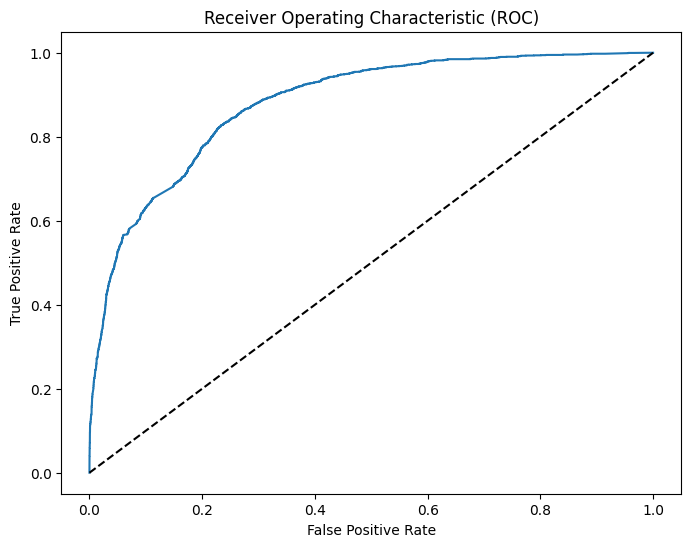

AUC Score: 0.8790403207799897


In [236]:
# ROC 곡선 생성
y_pred_proba  = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # 기준 선 (랜덤 모델)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.show()
#auc 계산
from sklearn.metrics import roc_curve, roc_auc_score
auc_score = roc_auc_score(y_test, y_pred_proba)

print("AUC Score:", auc_score)

In [237]:
#KS Score
from scipy import interpolate
from scipy import spatial
from scipy import stats
from scipy.cluster import hierarchy

prediction_TN = clf.predict(X_test)

print('TabNet 모델 KS Score :')
stats.ks_2samp(pd.DataFrame(prediction_TN)[y_test==0].values.flatten(), 
               pd.DataFrame(prediction_TN)[y_test==1].values.flatten())

TabNet 모델 KS Score :


KstestResult(statistic=0.3931323720783582, pvalue=3.0381637092295646e-233, statistic_location=0, statistic_sign=1)

In [228]:
print(classification_report(y_test, prediction_TN))
f1_score(y_test, prediction_TN)

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      8644
           1       0.67      0.70      0.69      2087

    accuracy                           0.88     10731
   macro avg       0.80      0.81      0.80     10731
weighted avg       0.88      0.88      0.88     10731



0.6867215041128085

In [229]:
cm1 = confusion_matrix(y_test,prediction_TN)
cmdf1 = pd.DataFrame(cm1, index=['실제값(0)', '실제값(1)'], columns=['예측값(0)', '예측값(1)'])
cmdf1

,예측값(0),예측값(1)
실제값(0),7937,707
실제값(1),626,1461


In [ ]:
# 그냥 확인하기에 피쳐종류가 30개나 되어 한눈에 들어오지 않는다.
print(clf.feature_importances_, '\n')

# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(clf.feature_importances_, index=dat.drop(['BIZ_NO', '결산년월', 'Target'], axis=1).columns)

# 내림차순 정렬을 이용한다
top15 = ser.sort_values(ascending=False)[:15]
print(top15)

[0.00000000e+00 1.02167311e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.88970654e-05 1.37950887e-03 2.15475297e-04
 1.09087859e-04 0.00000000e+00 0.00000000e+00 1.36293297e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.33744324e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.88367450e-03 0.00000000e+00 0.00000000e+00
 2.58082444e-02 1.74915292e-01 1.68082024e-01 2.51814957e-01
 6.16173623e-02 4.90963057e-08 0.00000000e+00 7.77980590e-03
 7.57735993e-02 2.06654915e-01] 

VENT_YN            0.251815
신생기업여부             0.206655
HDOF_BR_GB         0.174915
FR_IVST_CORP_YN    0.168082
Stock_OX           0.075774
MDSCO_PRTC_YN      0.061617
재무결측치

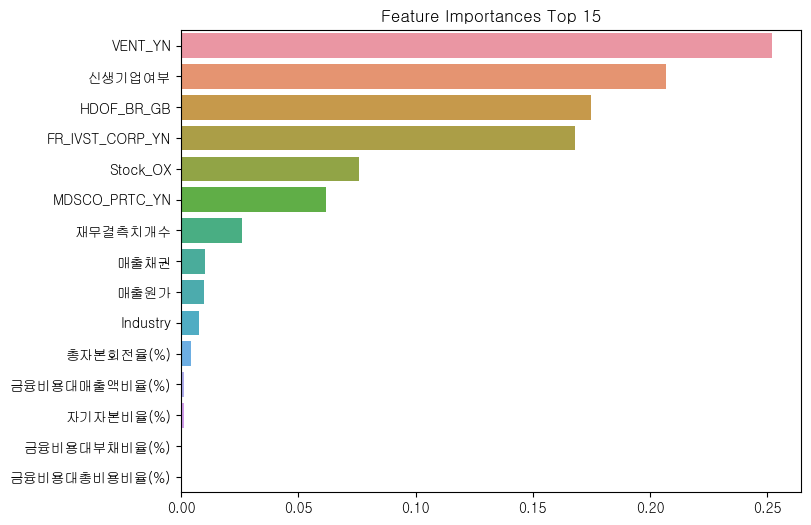

In [ ]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns

font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()
